In [1]:
import pandas_profiling 
import pandas as pd

In [2]:
data = pd.read_csv('datasets/operations.csv',parse_dates=[1,2])
pandas_profiling.ProfileReport(data)

Number of variables,7
Number of observations,308
Total Missing (%),14.3%
Total size in memory,16.9 KiB
Average record size in memory,56.3 B
Numeric,4
Categorical,1
Boolean,0
Date,2
Text (Unique),0
Rejected,0


In [3]:
import numpy as np
import pandas as pd
%matplotlib inline

In [4]:
data = pd.read_csv('datasets/operations.csv',parse_dates=[1,2])
data.head(5)

,identifiant_transaction,date_operation,date_valeur,libelle,debit,credit,solde
0,242,2023-10-06,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92,NaN,2513.79
1,25,2023-10-06,2023-10-06,CARTE XX XX CHEZ LUC XX,-10.00,NaN,2529.29
2,69,2023-10-06,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,NaN,2515.71
3,299,2023-10-05,2023-10-05,CARTE XX XX XX XX XX XX,-10.64,NaN,2539.29
4,45,2023-10-05,2023-10-05,CARTE XX XX XX XX,-4.80,NaN,2549.93


In [5]:
from collections import Counter

def most_common_words(labels):
    words=[]
    for lab in labels:
        words += lab.split(" ")
    counter = Counter(words)
    
    for word in counter.most_common(100):
        print(word)
    return words
words = most_common_words(data['libelle'])

('XX', 1428)
('CARTE', 247)
('VIREMENT', 29)
('LES', 20)
('ANCIENS', 20)
('ROBINSON', 20)
('CHEZ', 16)
('LUC', 16)
('LA', 16)
("L'EPICERIE", 16)
('DEMBAS', 16)
('TOUPTIPRI', 12)
('CCNCF', 9)
('RETRAIT', 9)
('PRELEVEMENT', 8)
('RAPT', 8)
('FORFAIT', 7)
('COMPTE', 7)
('SUPERBANK', 7)
('TELEPHONE', 7)
('DON', 7)
('LOUVE', 7)
('PERMANENT', 6)
('LOYER', 6)
('VELOC', 4)


In [6]:
CATEGS = {
    'LOYER': 'LOYER',
    'FORFAIT COMPTE SUPERBANK': 'COTISATION BANCAIRE',
    'LES ANCIENS ROBINSON': 'COURSES',
    "L'EPICERIE DENBAS": 'COURSES',
    'TELEPHONE': 'FACTURE TELEPHONE',
    'LA CCNCF': 'TRANSPORT',
    'CHEZ LUC': 'RESTAURANT',
    'RAPT': 'TRANSPORT',
    'TOUPTIPRI': 'COURSES',
    'LA LOUVE': 'COURSES',
    'VELOC': 'TRANSPORT'
}
TYPES = {
    'CARTE': 'CARTE',
    'VIR': 'VIREMENT',
    'VIREMENT': 'VIREMENT',
    'RETRAIT': 'RETRAIT',
    'PRLV': 'PRELEVEMENT',
    'DON': 'DON',
}

In [7]:
EXPENSES = [80,200]
LAST_BALANCE = 2400
WEEKEND = ["Saturday, Sunday"]

* date_operation
* libelle
* montant
* sens : indique si l'opération est un crédit ou un débit
* solde_avt_operation : elle indique le solde restant avant que l'opération ne soit effectuée
* categ : qui indique la catégorie de l'opération, par exemple : "courses", "loyer", "facture", etc.
* type : indiquant le type d'opération, exemple : "virement", "paiement par carte", 'retrait", etc.
* tranche_depense : si l'opération est une dépense, indique si celle-ci est petite, moyenne, etc.
* annee : l'année, déduite de date_operation
* mois : le mois, déduit de date_operation
* jour : le jour du mois (compris entre 1 et 31)
* jour_sem : le jour de la semaine (lundi, mardi, etc.)
* jour_sem_num : le numéro du jour de la semaine (compris entre 1 et 7)
* weekend : indique si la date d'opération se situe sur un weekend
* quart_mois : vaut 1, 2, 3 ou 4, et indique l'avancée dans le mois (1 : début, ..., 4 : fin de mois)

In [8]:
# Controle des colonnes
for c in ['date_operation','libelle','debit','credit']:
    if c not in data.columns:
        if (c in ['debit','credit'] and 'montant' not in data.columns) or \
        (c not in ['debit','credit']):
            msg = "Il vous manque la colonne '{}'. Attention aux majuscules "
            msg += "et minuscules dans le nom des colonnes!"
            raise Exception(msg.format(c))

# Suppression des colonnes innutiles
for c in data.columns:
    if c not in ['date_operation','libelle','debit','credit','montant']:
        del data[c]

In [9]:
if 'montant' not in data.columns:
    data['debit'].fillna(0,inplace= True)
    data['credit'].fillna(0,inplace=True)
    data['montant'] = data['debit'] + data['credit']
    del data["credit"], data['debit']
data.head(2)

,date_operation,libelle,montant
0,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92
1,2023-10-06,CARTE XX XX CHEZ LUC XX,-10.00


In [10]:
data.sort_values(by='date_operation',ascending=False, inplace=True)
data.head(2)

,date_operation,libelle,montant
0,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92
2,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58


In [11]:
# creation de la variable 'solde_avt_ope'
cumsum = np.cumsum(data['montant']).values
data['solde_avt_ope'] = LAST_BALANCE - cumsum
data.head(2)

,date_operation,libelle,montant,solde_avt_ope
0,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92,2401.92
2,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,2415.50


In [12]:
# Assignation des operations a une categorie et a un type
# ex on veut assigner un libelle contenant "Transport" à la categorie TRANSPORT.
# utiliser le dictionnaire Categ

def detect_words(values, dic):
    result = []
    for lib in values:
        operation_type= "AUTRE"
        for word in np.unique(lib.split(" ")):
            if word in dic.keys():
                operation_type = dic[word] 
        result.append(operation_type)
    return result

data['categ'] = detect_words(data['libelle'],CATEGS)
data['type'] = detect_words(data['libelle'],TYPES)
data.head(2)

,date_operation,libelle,montant,solde_avt_ope,categ,type
0,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92,2401.92,AUTRE,AUTRE
2,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,2415.50,FACTURE TELEPHONE,AUTRE


In [13]:
# creation de la variable  'sens'
data['sens'] = ['credit' if m > 0 else 'debit' for m in data['montant']]
data.head(2)

,date_operation,libelle,montant,solde_avt_ope,categ,type,sens
0,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92,2401.92,AUTRE,AUTRE,debit
2,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,2415.50,FACTURE TELEPHONE,AUTRE,debit


In [14]:
# creation de la variable 'tranche_depense'
def expense_slice(value):
    value= - value
    if value < 0:
        return "(pas une dépense)"
    elif value < EXPENSES[0]:
        return "petite"
    elif value < EXPENSES[1]:
        return "moyenne"
    else:
        return "grosse"
data['tranche_depense'] = data['montant'].map(expense_slice)

In [15]:
a = data['date_operation'][0]

In [16]:
a.quarter

4

In [17]:
#année
data['annee'] = data['date_operation'].map(lambda d: d.year)
data['mois'] = data['date_operation'].map(lambda d: d.month)
data['jour'] = data['date_operation'].map(lambda d: d.day)
data['jour_sem'] = data['date_operation'].map(lambda d: d.day_name())
data['jour_sem_num'] = data['date_operation'].map(lambda d: d.weekday()+1)
data['quart_mois'] = data['date_operation'].map(lambda d: d.quarter)
data["weekend"] = data["jour_sem"].isin(WEEKEND)

In [18]:
data.head(2)

,date_operation,libelle,montant,solde_avt_ope,categ,type,sens,tranche_depense,annee,mois,jour,jour_sem,jour_sem_num,quart_mois,weekend
0,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92,2401.92,AUTRE,AUTRE,debit,petite,2023,10,6,Friday,5,4,False
2,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,2415.50,FACTURE TELEPHONE,AUTRE,debit,petite,2023,10,6,Friday,5,4,False


### Variable quantitatives : operation arithmétique dessus
* Discrets
* Continue

### Variable qualitatives : 
* Nominale = NOM1, NOM2, NOM3
* Ordinale = petit, moyen, gros. Dates (timestamp) = nb de secondes depuis le 1er janvier 1970.
* Dichotomiques = 0 ou 1, Vrai/Faux ... (binaire ou booléen)

### Distributions empiriques
* tuyau d'orgue (quali)
* en batons (quanti discrete)
* histogramme = quanti continue

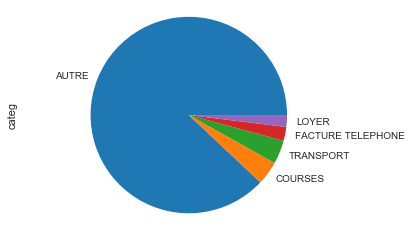

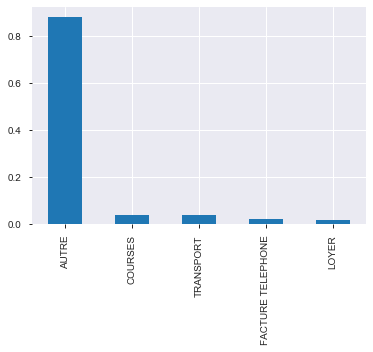

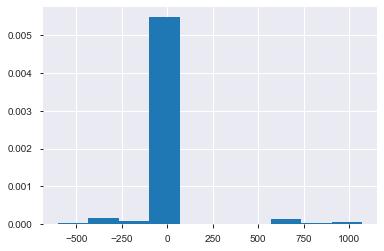

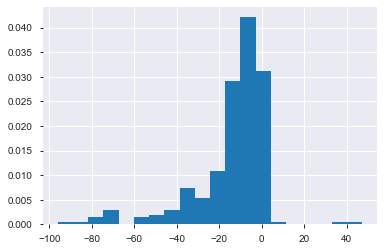

In [19]:
import matplotlib.pyplot as plt

# Variable qualitative 
# Diagramme en secteur
data['categ'].value_counts(normalize=True).plot(kind='pie')
plt.axis('equal')
plt.show()

# Diagramme en tuyaux d'orgues
data['categ'].value_counts(normalize=True).plot(kind='bar')
plt.show()

# Histogramme
data["montant"].hist(density=True)
plt.show()

# Histogramme plus beau
data[data.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()

In [20]:
# Recaputulatif de la variable quart_mois
effectifs = data['quart_mois'].value_counts()
modalites = effectifs.index

tab = pd.DataFrame(modalites,columns=['quart_mois'])
tab['n'] = effectifs.values
tab['f'] = effectifs.values / len(data)
tab['F'] = tab['f'].values.cumsum()
tab

,quart_mois,n,f,F
0,3,158,0.512987,0.512987
1,2,142,0.461039,0.974026
2,4,7,0.022727,0.996753
3,1,1,0.003247,1.000000


## Indicateurs Statistiques:
* mesure, indicateur, indice, donnée = plus ou moins la même chose
* indicateur => neutre, indice => philosophique
* calcule a partir d'un echantillon => perte d'informations

# Analyze univariée
## Mesure de tendance centrale
* Mode : [40min,45min], "Autre" = + haute frequence
* Moyenne
* Mediane

In [21]:
print(data['montant'].mean())
print(data['montant'].median())
print(data['montant'].mode())

2.872564935064931
-9.6
0   -1.6
dtype: float64


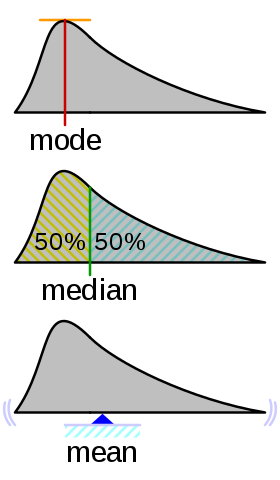

## Dispersion
* variance empirique $v=\frac{1}{n}\sum_{i=1}^{n}(x_i-\overline{x})^2 =(\frac{1}{n}\sum_{i=1}^{n}x_i^2)-\overline{x}^2$
* variance enmpirique sans biais $s'^2=\frac{n}{n-1}v$
* ecart type empirique $s = \sqrt{v}$
* ecart inter-quartiles / deciles (0.1,0.2..) / centiles(0.01,0.02...)
* boite à moustaches - boxplot
* coefficient de variation : $CV = \frac{std}{\overline{x}}$
* ecart moyen absolu : $EMA = \frac{1}{n}\sum_{i=1}^{n}{|x_i - Med|}$

--------------------
AUTRE
moy:
 13.688044280442801
med:
 -9.31
mod:
 0   -1.6
dtype: float64
var:
 32158.272268868866
ect:
 179.3272769794625


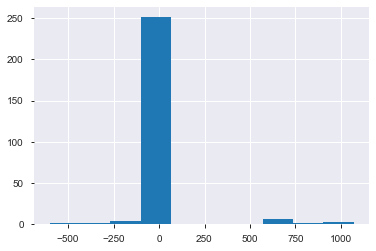

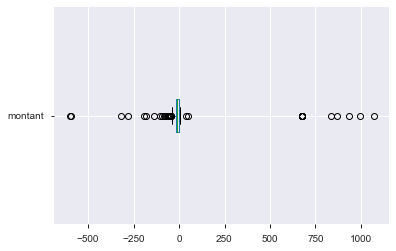

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714284
med:
 -7.02
mod:
 0   -7.02
1   -6.38
dtype: float64
var:
 105.01905306122451
ect:
 10.247880417980321


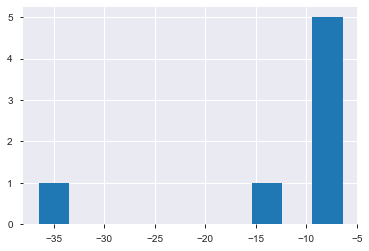

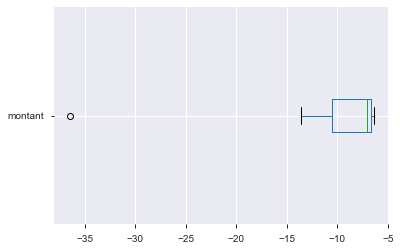

--------------------
COURSES
moy:
 -7.715833333333333
med:
 -8.1
mod:
 0    -13.59
1    -12.96
2    -12.24
3    -10.36
4     -9.88
5     -9.60
6     -6.60
7     -5.88
8     -3.48
9     -2.93
10    -2.56
11    -2.51
dtype: float64
var:
 16.40380763888889
ect:
 4.050161433682476


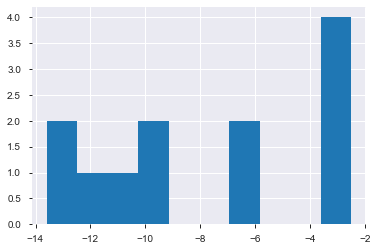

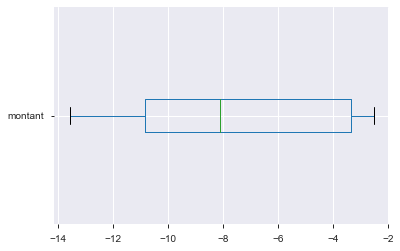

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
dtype: float64
var:
 0.0
ect:
 0.0


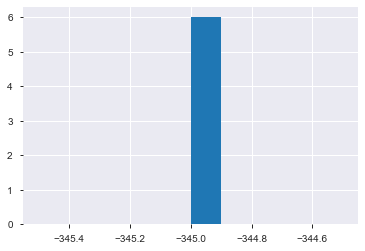

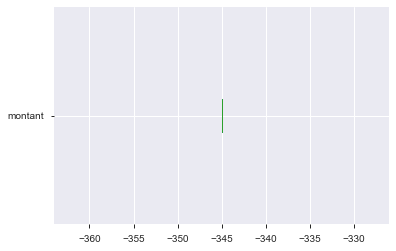

--------------------
TRANSPORT
moy:
 -48.15
med:
 -73.0
mod:
 0   -73.0
dtype: float64
var:
 965.5158333333333
ect:
 31.072750656054467


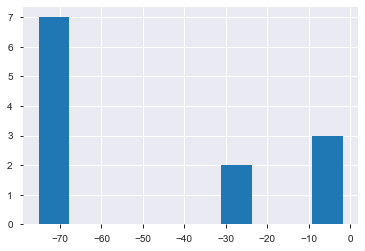

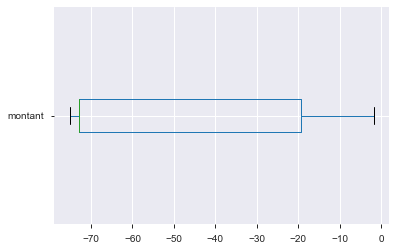

In [22]:
for cat in data["categ"].unique():
    subset = data[data.categ == cat]
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    print("var:\n",subset['montant'].var(ddof=0))
    print("ect:\n",subset['montant'].std(ddof=0))
    subset["montant"].hist()
    plt.show()
    subset.boxplot(column="montant", vert=False)
    plt.show()

## Mesures de forme - asymétrie

* <b>Skewness empirique :</b> γ = $\frac{\frac{1}{n}\sum_{i=1}^{n}(x_i-\overline{x})^3}{s^3} =  \frac{\mu_3}{s^3}$
* Si γ1=0 alors la distribution est symétrique, γ1>0 =>étalée à droite, γ1<0 => étalée à gauche.
* Autre methode : $\frac{3 (moy - med)}{std}$

## Mesure d'applatissement 
* <b>Kurtosis empirique :</b> $\gamma_2 = \frac{\mu_4}{s^4}-3$ 
* Si γ2=0 => même applatissement que la distrib. normale, γ2>0 => plus concentrée, γ2<0 => plus applatie.


--------------------
AUTRE
moy:
 13.688044280442801
med:
 -9.31
mod:
 0   -1.6
dtype: float64
var:
 32158.272268868866
ect:
 179.3272769794625
skw:
 3.5849014739148974
kur:
 17.107938653544064


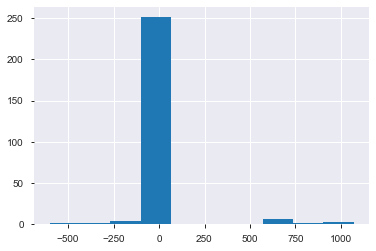

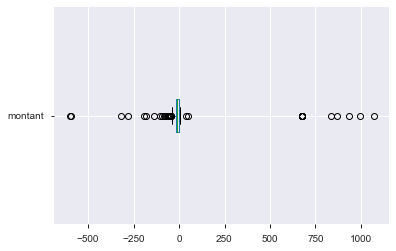

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714284
med:
 -7.02
mod:
 0   -7.02
1   -6.38
dtype: float64
var:
 105.01905306122451
ect:
 10.247880417980321
skw:
 -2.387651456428151
kur:
 5.798563367885487


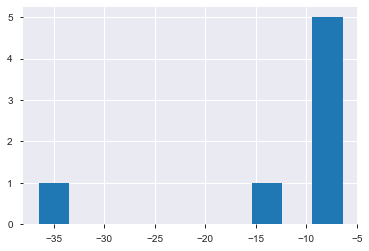

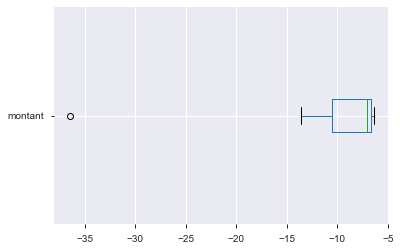

--------------------
COURSES
moy:
 -7.715833333333333
med:
 -8.1
mod:
 0    -13.59
1    -12.96
2    -12.24
3    -10.36
4     -9.88
5     -9.60
6     -6.60
7     -5.88
8     -3.48
9     -2.93
10    -2.56
11    -2.51
dtype: float64
var:
 16.40380763888889
ect:
 4.050161433682476
skw:
 -0.005039992931786665
kur:
 -1.6960917797241195


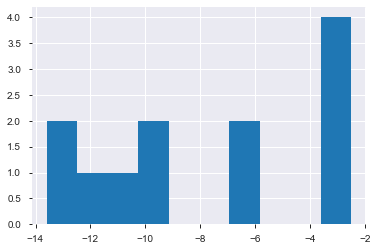

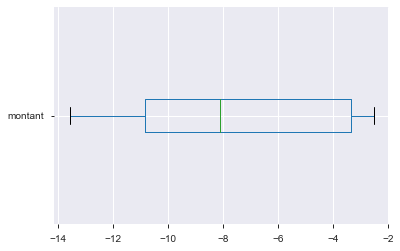

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
dtype: float64
var:
 0.0
ect:
 0.0
skw:
 0
kur:
 0


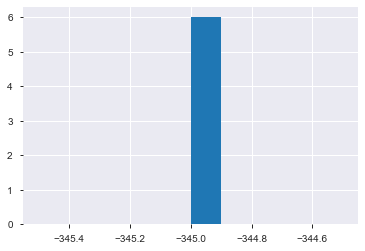

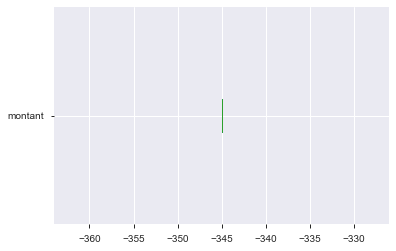

--------------------
TRANSPORT
moy:
 -48.15
med:
 -73.0
mod:
 0   -73.0
dtype: float64
var:
 965.5158333333333
ect:
 31.072750656054467
skw:
 0.5720202155363941
kur:
 -1.783336608969416


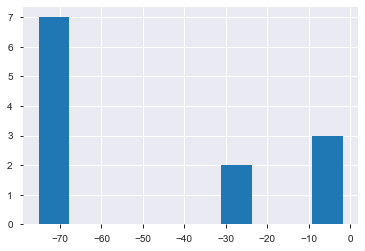

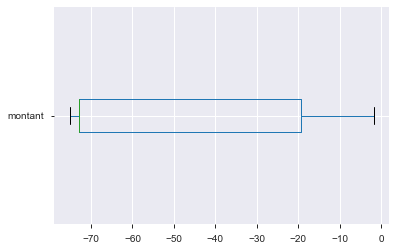

In [23]:
for cat in data["categ"].unique():
    subset = data[data.categ == cat]
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    print("var:\n",subset['montant'].var(ddof=0))
    print("ect:\n",subset['montant'].std(ddof=0))
    print("skw:\n",subset['montant'].skew())
    print("kur:\n",subset['montant'].kurtosis())
    subset["montant"].hist()
    plt.show()
    subset.boxplot(column="montant", vert=False)
    plt.show()

## Symétrie : 
* Mode = Moy = Med => distrubtion symétrique.
* Mode < Med < Moy => étalée à droite
* Mode > Med > Moy => étalée à gauche

## Moments : 
* Moment général empirique d'ordre p par rapport à t 
* Moment simple empirique d'ordre p par rapport à t = 0 
* Moment centré empirique d'ordre p par rapport à t = Moy 

## Mesure de concentration - Courbe de Lorenz
* Etudier la concentration d'argent c'est regarder si l'argent est répartie de manière égalitaire ou pas.
* Si tout le monde a la même somme d'argent, alors la courbe est linéaire = "première bissectrice".
* Indice de Gini : Aire entre première bissectrice et la courbe de Lorenz : $gini =2*S$
* Loi de Pareto :" Les 20% les plus riches possèdent 80% des richesses mondiales.

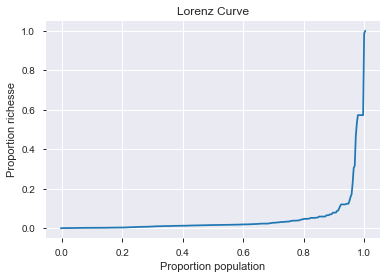

In [24]:
depenses = data[data['montant']<0] 
n = len(depenses)
depenses = (- depenses['montant']).sort_values().values
depenses /= depenses[-1]
lorenz = np.append([0],depenses)
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
plt.title('Lorenz Curve')
plt.xlabel('Proportion population')
plt.ylabel('Proportion richesse')
plt.show()

In [25]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n 
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print('gini:',gini)

gini: 0.9047441760573984


<b>Valeur médiale :</b> valeur du montant à la moitié de l'axe y. => on recupere ainsi l'individu avec le salaire médiale.

## Moyennes
* Taux de croissance : $\tau_{t/0} = \frac{X_t-X_0}{X_0}$
* Arithmétique
* Géométrique ex: taux de croissance moyen. $\left[ \left( 1.2\right) ^{2}\times\left( 1.1\right) ^{4}\times\left( 1\right) \right] ^{\frac{1}{7}}-1\simeq0.114=11.4\%$
* Harmonique ex: moyenne de pourentage et de rapport => rouler à 60km/h à l'aller puis à 30km/h au retour, vitesse moyenne = $\frac{2}{\frac{1}{60}+\frac{1}{30}}$. Elle est aussi utilisée quand on veut trouver un bon compromis entre deux mesures a et b (toutes deux positives) où a grandit quand b diminue. Pour rester dans les exemples d'automobilistes, disons que a désigne la vitesse à laquelle on roule, et b une mesure de sécurité de la conduite. A partir d'un certain point, si a est trop important, alors la conduite sera très peu sûre et donc b sera très bas. On veut trouver un bon compromis entre vitesse et sécurité. On peut le faire par la moyenne harmonique : 2×a×b/a+b 
<br> <br>

* Quadratique ex: RMSE.


# Analyse bivariée : Deux variables

In [26]:
montant = data['montant']
solde = data['solde_avt_ope']

np.corrcoef(montant,solde)

array([[ 1.        , -0.16849089],
       [-0.16849089,  1.        ]])

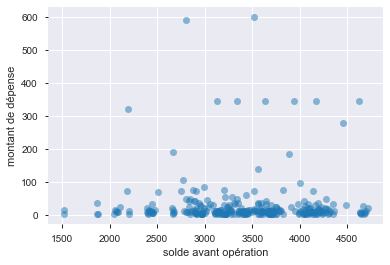

In [27]:
import matplotlib.pyplot as plt

depenses = data[data.montant < 0]
plt.plot(depenses["solde_avt_ope"],-depenses["montant"],'o',alpha=0.5)
plt.xlabel("solde avant opération")
plt.ylabel("montant de dépense")
plt.show()

In [28]:
import scipy.stats as st
import numpy as np

print(st.pearsonr(depenses["solde_avt_ope"],-depenses["montant"])[0])
print(np.cov(depenses["solde_avt_ope"],-depenses["montant"],ddof=0)[0,1])

0.004801442042475884
228.1663306444196


# ANOVA 

In [29]:
X = "categ" # qualitative
Y = "montant" # quantitative

# On ne garde que les dépenses
sous_echantillon = data[data["montant"] < 0].copy()
# On remet les dépenses en positif
sous_echantillon["montant"] = -sous_echantillon["montant"]
# On n'étudie pas les loyers car trop gros:
sous_echantillon = sous_echantillon[sous_echantillon["categ"] != "LOYER"] 

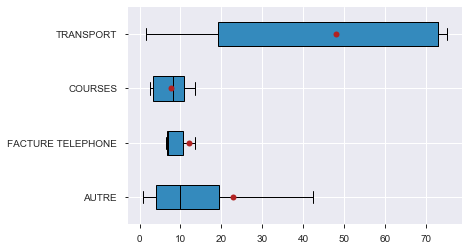

In [30]:
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

ANOVA quanti + quali

In [31]:
X = "categ" # qualitative
Y = "montant" # quantitative

sous_echantillon = data[data["montant"] < 0] # On ne garde que les dépenses

# variation interclasse / variation totale
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.388428234458321

Analyse bivariée - Test de chi-2 a partir du tableau de contingence

In [32]:
X = "quart_mois"
Y = "categ"

cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len, margins=True, margins_name="Total")
cont

categ,AUTRE,COURSES,FACTURE TELEPHONE,LOYER,TRANSPORT,Total
quart_mois,,,,,,
1,1.0,NaN,NaN,NaN,NaN,1
2,123.0,6.0,3.0,3.0,7.0,142
3,141.0,6.0,3.0,3.0,5.0,158
4,6.0,NaN,1.0,NaN,NaN,7
Total,271.0,12.0,7.0,6.0,12.0,308


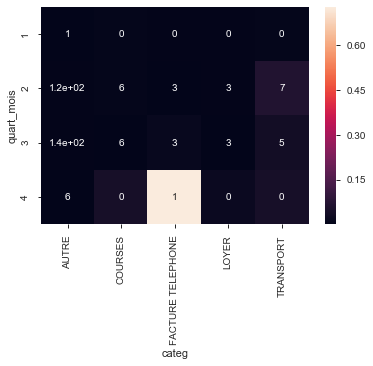

In [33]:
import seaborn as sns

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep # continent les Eps_i,j de chaque case du tableau = erreur entre theorique et réalisé
xi_n = measure.sum().sum()
table = measure/xi_n # normalise par Eps_n (erreur totale du tableau) pour avoir une valeur en 0 et 1.
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()